In [2]:
## loading libraries
library(repr)
library(tidyverse)
library(tidymodels)
library(RCurl)
library(RColorBrewer)
options(repr.matrix.max.rows = 6)

In [4]:
## read data on .csv file from GitHub 
url <- getURL("https://raw.githubusercontent.com/nitahieb/dsci100project/master/atp2017-2019.csv")
tennis_data_raw <- read_csv(url)

Warning message:
“Missing column names filled in: 'X1' [1]”


In [5]:
## cleaning and wrangling data
## removed unneccessary columns and mutated columns for which we would use for our data analyses
tennis_data <- tennis_data_raw %>%
    select(-X1) %>%
    mutate(rank_diff = abs((winner_rank - loser_rank)), age_diff = (winner_age - loser_age)) %>%
    mutate(higher_rank_win = (winner_rank < loser_rank)) %>%
    select(rank_diff, age_diff, higher_rank_win)

In [6]:
## setting seed to keep data random
set.seed(9999)

#splitting the original data set into a training and testing data set. 
tennis_split <- initial_split(tennis_data, prop = 0.75, strata = higher_rank_win, na.rm=TRUE)
tennis_train_temp <- training(tennis_split)
tennis_test_temp <- testing(tennis_split)

#removing any NA logicals from training data & testing data
tennis_train <- na.omit(tennis_train_temp)
tennis_test <- na.omit(tennis_test_temp)

In [7]:
## exploratory data analysis
tennis_train

## rank_diff represents the ranking difference between the winner and the loser of the tennis
## match. 

## age_diff represents the age difference between the winner and loser of the tennis match.
## A negative age_diff represents that the loser was older, while a positive age_diff 
## represents that the winner was older.

## our chosen predictor variable is higher_rank_win which represents a logical about if the
## higher ranked player was able to defeat the lower ranked player in the tennis match. 

## through the use of na.omit(), we are able to begin our analyses with rows that are not 
## missing data.

## below represents a couple data points representing rank_diff, age_diff, and if the 
## higher ranked player won or not.

rank_diff,age_diff,higher_rank_win
<dbl>,<dbl>,<lgl>
7,6.119097,TRUE
31,-2.877481,TRUE
208,13.837098,FALSE
⋮,⋮,⋮
6,-2.1464750,TRUE
2,-0.4380561,TRUE
11,3.2142368,TRUE


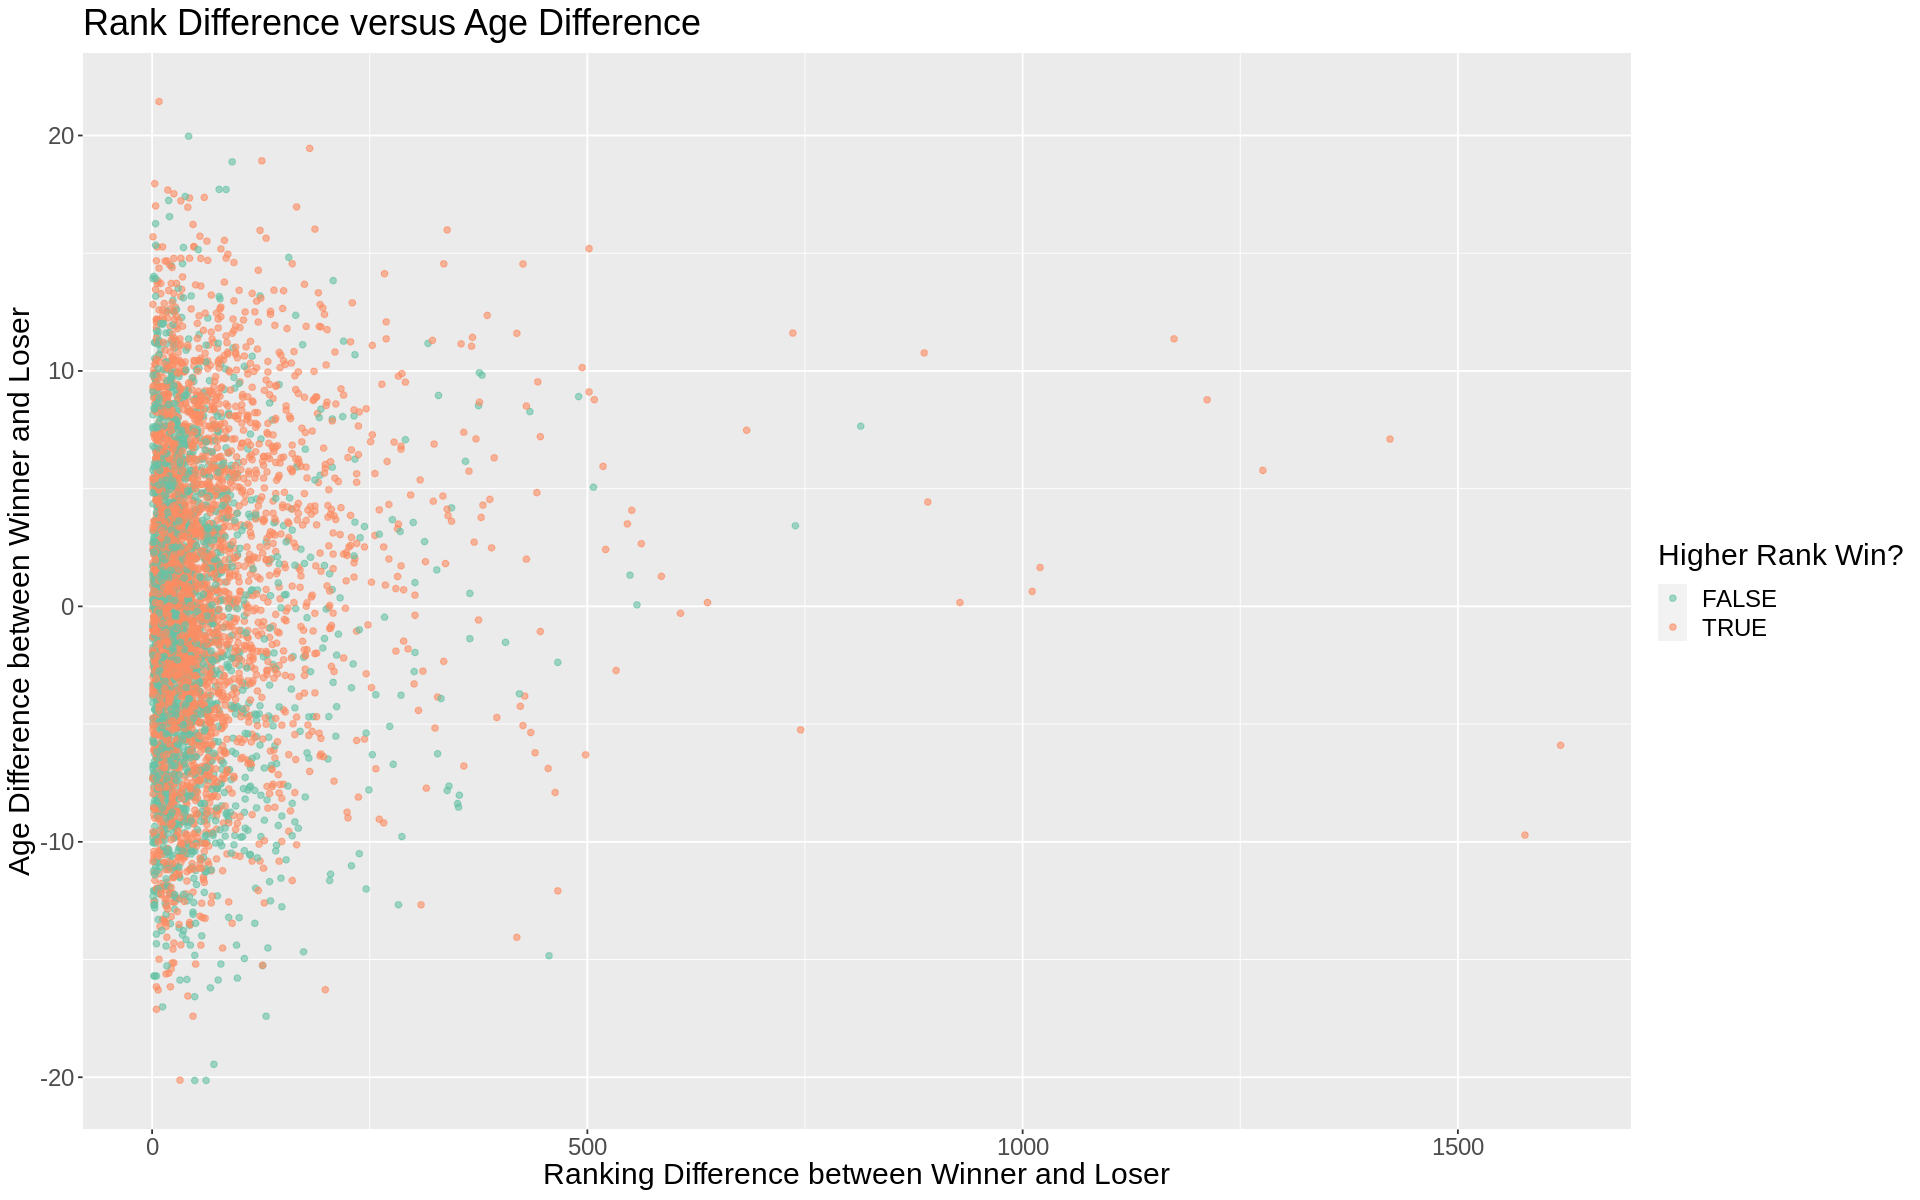

In [8]:
## plotting of the data
options(repr.plot.width = 16, repr.plot.height = 10)

## this visualization aims to compare the relationship between ranking difference and age difference
## between winner and loser of tennis matches. 

## Higher Rank Win? represents if the Higher Ranked Player won:
## FALSE: higher ranked player lost
## TRUE:  higher ranked player won

## from this visualization there seems to be consistency where the predictor, higher_rank_win, will
## be from the difference in rank and difference in age.

tennis_train_plot <- tennis_train %>%
                     ggplot(aes(x = rank_diff, y = age_diff, color = higher_rank_win)) +
                     geom_point(alpha = 0.6) +
                     labs(x = "Ranking Difference between Winner and Loser", y = "Age Difference between Winner and Loser", color = "Higher Rank Win?") +
                     ggtitle("Rank Difference versus Age Difference") +
                     theme(text = element_text (size = 18)) +
                     scale_color_brewer(palette = "Set2")
tennis_train_plot

In [9]:
# converting <lgl> data type to <fct> data type

# even though we are working with logicals for our predictor variables, in order to perform KNN, we need to
# convert our <lgl> data type into <fct> data type for KNN to work.

# we are not able to perform n-fold cross validation or classification through K-Nearest Neighbors without
# our data in <fct>
tennis_train <- tennis_train %>%
                mutate(higher_rank_win = as.factor(higher_rank_win))
tennis_test <- tennis_test %>%
                mutate(higher_rank_win = as.factor(higher_rank_win))
tennis_train

rank_diff,age_diff,higher_rank_win
<dbl>,<dbl>,<fct>
7,6.119097,TRUE
31,-2.877481,TRUE
208,13.837098,FALSE
⋮,⋮,⋮
6,-2.1464750,TRUE
2,-0.4380561,TRUE
11,3.2142368,TRUE


In [10]:
set.seed(4532)

# performing n-fold cross validation on training data. 

# 5-fold cross-validation performed on training data
# 5 folds wer chosen because the performance of R and JupyterHub was much faster in contrast to 10 folds 
tennis_vfold <- vfold_cv(tennis_train, v = 5, strata = higher_rank_win)

# creating recipe for training data set
tennis_train_recipe <- recipe(higher_rank_win ~ age_diff + rank_diff, data = tennis_train) %>%
                    step_scale(all_predictors()) %>%
                    step_center(all_predictors())

# K-Nearest Neighbors Model Specification with tune()
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
                set_engine("kknn") %>%
                set_mode("classification")

# workflow analysis with cross-validation
tennis_fit <- workflow() %>%
                add_recipe(tennis_train_recipe) %>%
                add_model(knn_tune) %>%
                tune_grid(resamples = tennis_vfold, grid = 10) %>%
                collect_metrics()

In [ ]:
set.seed(4532)

# what K integer value should we use for the neighbors = ... parameter in K-Nearest Neighbors?

# choosing an upper, lower limit and the amount of steps to visualize which K integer value is
# most optimal for the Neighbors parameter for classification for K-Nearest Neighbors 
k_vals <- tibble(neighbors = seq(from = 150, to = 200, by = 1)) 

# we were able to come to the conlusion to use a range between K is between [150,200] by plotting accuracies with 
# k_vals <- tibble(neighbors = seq(from = 0, to = 100, by = 5)) - we needed to observe outside the K = 100 range
# k_vals <- tibble(neighbors = seq(from = 0, to = 500, by = 1)) - classifier accuracy becomes very similar after K > 300

# creating seperate workflow()
knn_results <- workflow() %>%
  add_recipe(tennis_train_recipe) %>%
  add_model(knn_tune) %>%
  tune_grid(resamples = tennis_vfold, grid = k_vals) %>%
  collect_metrics() 

# filtering for (.metric == "accuracy")
accuracies <- knn_results %>%
                filter(.metric == "accuracy")

# plotting accuracies against the K interger value within the range of (150 ,200)
accuracy_vs_k <- accuracies %>%
                  ggplot(aes(x = neighbors, y = mean)) +
                  geom_point() +
                  geom_line() + 
                  labs(x = "Neighbors", y = "Accuracy Estimate") +
                  theme(text = element_text(size = 20))

#from this graph, we can conclude that the most optimal K integer value to represent neighbors is 170.

In [26]:
# working with testing data and new K value

# creating new recipe using testing tennis data set
tennis_test_recipe <- recipe(higher_rank_win ~ age_diff + rank_diff, data = tennis_test) %>%
                step_scale(all_predictors()) %>%
                step_center(all_predictors())

# recreating K-Nearest Neighbors Classification Specification for testing data
knn_test_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 170) %>%
                    set_engine("kknn") %>%
                    set_mode("classification")

# retraining classifier using new recipe, model specification, and testing data
tennis_test_fit <- workflow() %>%
            add_recipe(tennis_test_recipe) %>%
            add_model(knn_test_spec) %>%
            fit(data = tennis_test)

# binding predictions to testing data
tennis_predictions <- predict(tennis_test_fit, tennis_test) %>%
                        bind_cols(tennis_test) 

# extracting prediction accuracy of the classifier
tennis_metrics <- tennis_predictions %>%
                        metrics(truth = higher_rank_win, estimate = .pred_class) %>%
                        filter(.metric == "accuracy")
tennis_metrics
# the classifier we have trained is 63.64% accurate

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6364169
